<img width="10%" alt="Naas" src="https://landen.imgix.net/jtci2pxwjczr/assets/5ice39g4.png?w=160"/>

# YahooFinance - k-NN - Find the stock with closest performance
<a href="https://app.naas.ai/user-redirect/naas/downloader?url=https://raw.githubusercontent.com/jupyter-naas/awesome-notebooks/master/template.ipynb" target="_parent">
<img src="https://img.shields.io/badge/-Open%20in%20Naas-success?labelColor=000000&logo="/>
</a>

**Tags:** #tool #naas_drivers #naas #scheduler #asset #snippet #automation #ai #analytics

**Author:** [Abhinav Lakhani](https://www.linkedin.com/in/abhinav-lakhani/)

Input:
List of stocks data

Model:
Find the stock with the closest performance attribute

Output:
Graph of clusters (with each cluster having a different color)

Resources / Inspiration:
https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7

## Input

### Import library

In [1]:
from naas_drivers import yahoofinance
import naas

In [2]:
from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
import numpy as np
from scipy.cluster.vq import kmeans,vq
import pandas as pd
import pandas_datareader as dr
from math import sqrt
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [3]:
import tensorflow as tf
print(tf.__version__)
import torch
print(torch.__version__)

2.6.0
1.8.1+cu102


### Variables

In [4]:
# Input
stock_name = 'NFLX'
date_from = -3600
date_to = "today"
moving_averages = [20,50]

# Output
csv_output = "MY_OUTPUT.csv"

### Schedule your notebook

In [5]:
# Schedule your notebook everyday at 9 AM
# naas.scheduler.add(cron="0 9 * * *")

#-> Uncomment the line below to remove your scheduler
# naas.scheduler.delete()

### Get data from yahoo finance (function description)

In [9]:
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
#read in the url and scrape ticker data
data_table = pd.read_html(sp500_url)
tickers = data_table[0]["Symbol"].tolist()
prices_list = []
for ticker in tickers:
    try:
        prices = yahoofinance.get(ticker,
                      date_from=date_from,
                      date_to=date_to,
                      moving_averages=moving_averages)['Adj Close']
#         prices = dr.DataReader(ticker,'yahoo','01/01/2017')['Adj Close']
        prices = pd.DataFrame(prices)
        prices.columns = [ticker]
        prices_list.append(prices)
    except:
        pass
    prices_df = pd.concat(prices_list,axis=1)
prices_df.sort_index(inplace=True)
prices_df.head()

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,MDLZ,MPWR,MNST,MCO,MS,MOS,MSI,MSCI,NDAQ,NTAP
0,67.140961,10.643416,26.436016,23.783298,24.150000,48.388145,11.179482,20.731382,30.650000,39.375381,...,21.822536,16.206861,23.940001,32.337456,11.694939,48.953430,38.018368,31.042662,19.277639,23.004425
1,68.567070,11.291558,26.225191,23.586918,23.930000,48.919342,11.568174,20.997652,31.430000,39.944519,...,21.915747,16.524124,23.966667,32.675415,11.409497,48.902977,38.851017,31.318027,19.396217,24.390821
2,68.536896,11.133318,26.173485,23.288944,23.709999,49.259632,11.429357,20.761814,31.889999,39.698601,...,22.041864,17.185087,22.610001,32.897751,10.805994,48.457260,39.558754,31.529129,19.319990,25.084021
3,67.903061,11.085631,25.879128,23.336349,23.330000,48.969147,11.114699,20.541187,31.379999,39.417530,...,22.019928,16.991209,21.656668,32.292988,10.422687,48.356342,38.717800,31.015121,18.947313,25.140440
4,67.427666,10.990250,25.712063,22.828449,22.520000,47.931656,11.049919,20.442284,30.639999,39.010017,...,21.493555,16.744444,22.053333,31.839399,10.308506,48.347927,38.209873,30.574541,18.760969,24.664871


## EDA

Text(0.5, 1.0, 'Elbow curve')

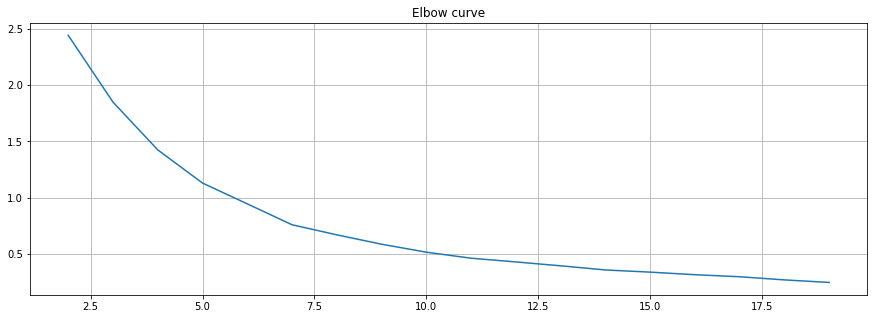

In [10]:
#Calculate average annual percentage return and volatilities over a theoretical one year period
returns = prices_df.pct_change().mean() * 252
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = prices_df.pct_change().std() * sqrt(252)
#format the data as a numpy array to feed into the K-Means algorithm
data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T
X = data
distorsions = []
for k in range(2, 20):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

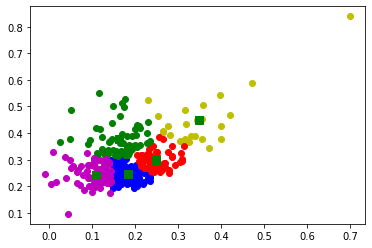

In [11]:
# computing K-Means with K = 5 (5 clusters)
centroids,_ = kmeans(data,5)
# assign each sample to a cluster
idx,_ = vq(data,centroids)
# some plotting using numpy's logical indexing
plot(data[idx==0,0],data[idx==0,1],'ob',
     data[idx==1,0],data[idx==1,1],'oy',
     data[idx==2,0],data[idx==2,1],'or',
     data[idx==3,0],data[idx==3,1],'og',
     data[idx==4,0],data[idx==4,1],'om')
plot(centroids[:,0],centroids[:,1],'sg',markersize=8)
show()

In [12]:
#identify the outlier
print(returns.idxmax())

Returns       ENPH
Volatility    ENPH
dtype: object


In [14]:
#drop the relevant stock from our data
returns.drop('ENPH',inplace=True)
#recreate data to feed into the algorithm
data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T

## Model

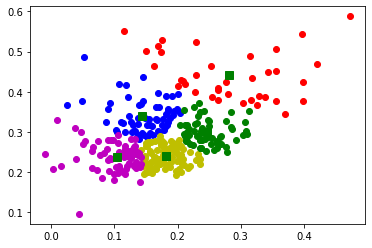

In [15]:
# computing K-Means with K = 5 (5 clusters)
centroids,_ = kmeans(data,5)
# assign each sample to a cluster
idx,_ = vq(data,centroids)
# some plotting using numpy's logical indexing
plot(data[idx==0,0],data[idx==0,1],'ob',
     data[idx==1,0],data[idx==1,1],'oy',
     data[idx==2,0],data[idx==2,1],'or',
     data[idx==3,0],data[idx==3,1],'og',
     data[idx==4,0],data[idx==4,1],'om')
plot(centroids[:,0],centroids[:,1],'sg',markersize=8)
show()

## Output

In [16]:
details = [(name,cluster) for name, cluster in zip(returns.index,idx)]
for detail in details:
    print(detail)

('MMM', 4)
('AOS', 1)
('ABT', 1)
('ABBV', 3)
('ABMD', 2)
('ACN', 1)
('ATVI', 3)
('ADM', 1)
('ADBE', 3)
('ADP', 1)
('AAP', 0)
('AES', 0)
('AFL', 1)
('A', 1)
('AIG', 0)
('APD', 1)
('AKAM', 0)
('ALK', 0)
('ALB', 3)
('ARE', 4)
('ALGN', 2)
('ALLE', 4)
('LNT', 1)
('ALL', 1)
('GOOGL', 3)
('GOOG', 3)
('MO', 4)
('AMZN', 3)
('AMCR', 4)
('AMD', 2)
('AEE', 1)
('AAL', 2)
('AEP', 1)
('AXP', 0)
('AMT', 1)
('AWK', 1)
('AMP', 3)
('ABC', 1)
('AME', 1)
('AMGN', 1)
('APH', 1)
('ADI', 3)
('ANSS', 1)
('ANTM', 3)
('AON', 1)
('APA', 2)
('AAPL', 3)
('AMAT', 2)
('APTV', 3)
('ANET', 2)
('AIZ', 1)
('T', 4)
('ATO', 1)
('ADSK', 3)
('AZO', 1)
('AVB', 4)
('AVY', 3)
('BKR', 0)
('BALL', 1)
('BAC', 3)
('BBWI', 2)
('BAX', 4)
('BDX', 1)
('WRB', 1)
('BBY', 2)
('BIO', 1)
('TECH', 1)
('BIIB', 0)
('BLK', 1)
('BK', 4)
('BA', 0)
('BKNG', 0)
('BWA', 0)
('BXP', 4)
('BSX', 3)
('BMY', 4)
('AVGO', 2)
('BR', 1)
('BRO', 1)
('CHRW', 4)
('CDNS', 3)
('CZR', 2)
('CPT', 4)
('CPB', 4)
('COF', 0)
('CAH', 4)
('KMX', 0)
('CCL', 0)
('CARR', 1)


### Save result in csv

In [ ]:
df.to_csv(csv_output, index=False)

### Share your output with naas

In [ ]:
naas.asset.add(csv_output)

#-> Uncomment the line below to remove your asset
# naas.asset.delete()